In [1]:
!pip install torch torchvision
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

from IPython.display import clear_output

# Download and load the CIFAR10 training dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transforms.ToTensor())

# Download and load the CIFAR10 test dataset
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transforms.ToTensor())

# Define data split percentages
train_split_percentage = 0.7
importance_split_percentage = 0.15
validation_split_percentage = 0.15

In [3]:
total_train_samples = len(train_dataset)

train_samples = int(total_train_samples * train_split_percentage)
importance_samples = int(total_train_samples * importance_split_percentage)
validation_samples = int(total_train_samples * validation_split_percentage)

# The remaining samples will form a temporary test set
test_samples = len(test_dataset)

train_subset, importance_subset, validation_subset = torch.utils.data.random_split(
    train_dataset, [train_samples, importance_samples, validation_samples]
)

print(f"Number of samples in training subset: {len(train_subset)}")
print(f"Number of samples in importance subset: {len(importance_subset)}")
print(f"Number of samples in validation subset: {len(validation_subset)}")
print(f"Number of samples in test dataset: {len(test_dataset)}")

Number of samples in training subset: 35000
Number of samples in importance subset: 7500
Number of samples in validation subset: 7500
Number of samples in test dataset: 10000


In [4]:
# Define the mean and standard deviation for CIFAR10 for normalization
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2470, 0.2435, 0.2616)

# Transformations for the training dataset (including augmentation)
train_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])

# Transformations for the importance and test datasets (no augmentation)
eval_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])

# Apply the transformations to the respective subsets
train_subset.dataset.transform = train_transforms
validation_subset.dataset.transform = eval_transforms
importance_subset.dataset.transform = eval_transforms
test_dataset.transform = eval_transforms

print("Transformations defined and applied to datasets.")

Transformations defined and applied to datasets.


In [5]:
from torch.utils.data import DataLoader

# Define batch size
batch_size = 100

# Create DataLoaders
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
importance_loader = DataLoader(importance_subset, batch_size=batch_size, shuffle=False)
validation_loader = DataLoader(validation_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"DataLoaders created with batch size: {batch_size}")
print(f"Number of batches in training loader: {len(train_loader)}")
print(f"Number of batches in importance loader: {len(importance_loader)}")
print(f"Number of batches in validation loader: {len(validation_loader)}")
print(f"Number of batches in test loader: {len(test_loader)}")

DataLoaders created with batch size: 100
Number of batches in training loader: 350
Number of batches in importance loader: 75
Number of batches in validation loader: 75
Number of batches in test loader: 100


In [6]:
import torch.nn as nn
from torchvision.models import resnet18

# Instantiate the ResNet18 model
model = resnet18(pretrained=False)

# Modify the final fully connected layer for CIFAR10 (10 classes)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

# Print the model architecture
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [7]:
import torch.nn as nn
import torch.optim as optim

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.001)

print("Loss function (CrossEntropyLoss) and optimizer (SGD) defined.")


Loss function (CrossEntropyLoss) and optimizer (SGD) defined.


In [8]:
num_epochs = 200

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
import matplotlib.pyplot as plt

def display_loss(loss):
    plt.figure(figsize=(12, 6))
    plt.plot(loss)
    plt.title("Training Loss Over Iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.xlim([0, len(loss)])
    plt.savefig("loss_cifar10_resnet.png", dpi=300)
    plt.show()

def display_epochloss(train_loss, val_loss):
    plt.figure(figsize=(12, 6))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title("Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.xlim([0, len(train_loss)])
    plt.savefig("epochloss_cifar10_resnet.png", dpi=300)
    plt.show()

def display_accuracy(accuracy):
    plt.figure(figsize=(12, 6))
    plt.plot(accuracy)
    plt.title("Test Accuracy Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.xlim([0, len(accuracy)])
    plt.ylim([0, 100])
    plt.savefig("accuracy_cifar10_resnet.png", dpi=300)
    plt.show()


In [10]:
def compute_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    class_accuracies = [0 for _ in range(10)]
    class_counts = [0 for _ in range(10)]
    with torch.no_grad():
        for data in data_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            for i in range(len(labels)):
                label = labels[i]
                class_counts[label] += 1
                if predicted[i] == label:
                    class_accuracies[label] += 1

    accuracy = 100 * correct / total
    for i in range(10):
        if class_counts[i] > 0:
            class_accuracies[i] = 100 * class_accuracies[i] / class_counts[i]
        else:
            class_accuracies[i] = 0.0
        
    model.train()
    return accuracy, class_accuracies

def compute_val_loss(model, data_loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for data in data_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    avg_loss = total_loss / len(data_loader)
    model.train()
    return avg_loss

[19, 350] loss: 0.122


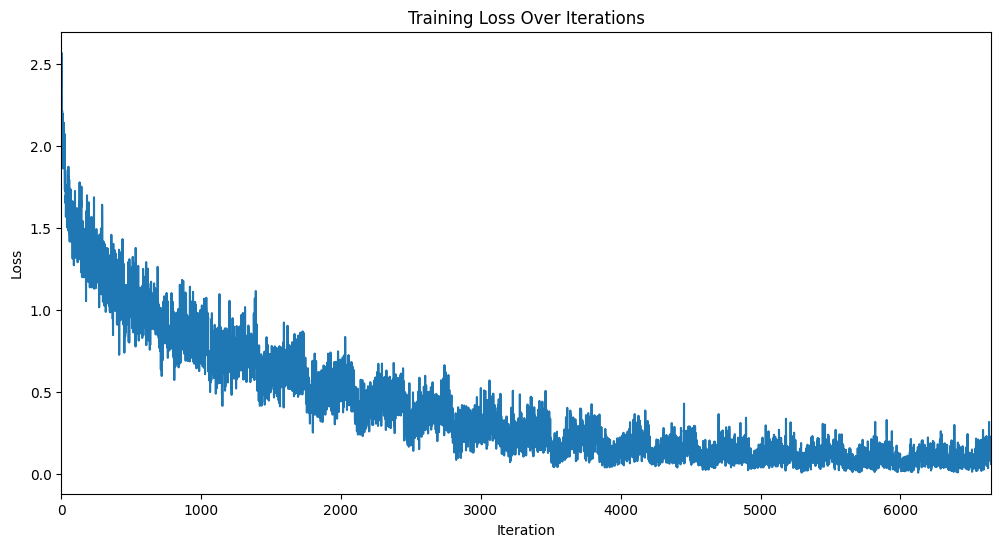

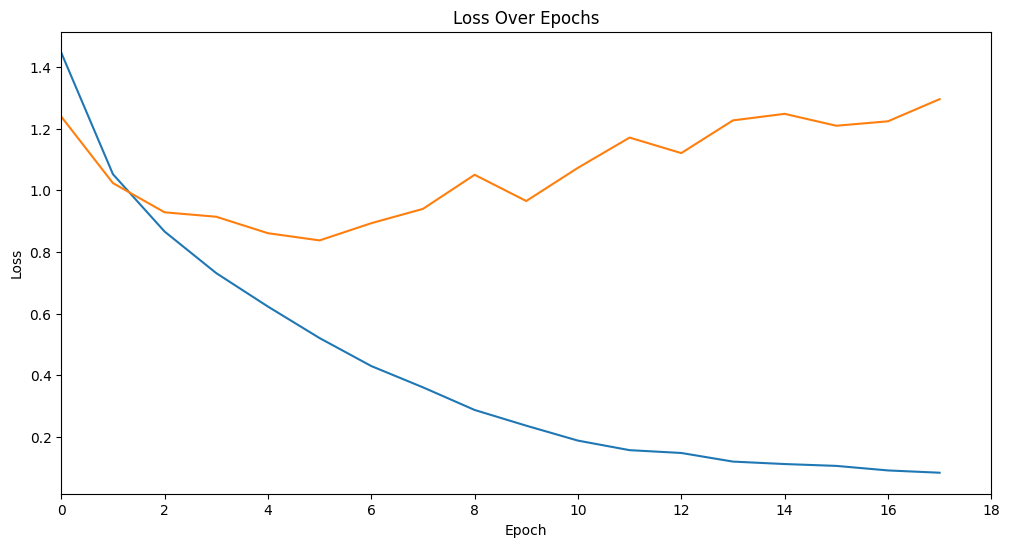

In [ ]:


print(f"Training model on {device}")

# Set the model to training mode
model.train()

loss_values = []
epoch_losses = []

val_losses = []

best_loss = float('inf')
best_epoch = -1

test_accuracies = []
test_class_accuracies = []

for epoch in range(num_epochs):  # Loop over the dataset multiple times

    running_loss = 0.0
    epoch_loss = 0.0
    count = 0

    for i, data in enumerate(train_loader, 0):
        clear_output(wait=True)

        # Get the inputs and labels
        inputs, labels = data

        # Move inputs and labels to the appropriate device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients of the optimizer
        optimizer.zero_grad()

        # Perform a forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, labels)
        loss_values.append(loss.item())

        # Perform a backward pass
        loss.backward()

        # Update the model's weights
        optimizer.step()

        # Print loss statistics
        running_loss += loss.item()
        epoch_loss += loss.item()
        count += 1

        if i % 50 == 49:    # print every 200 mini-batches
            print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 50:.3f}')
            running_loss = 0.0
            # Display the loss curve
            display_loss(loss_values)
            display_epochloss(epoch_losses, val_losses)
            clear_output(wait=True)
            
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        best_epoch = epoch

        torch.save(model.state_dict(), 'best_cifar10_resnet18.pth')
    epoch_losses.append(epoch_loss/350)
    val_losses.append(compute_val_loss(model, validation_loader, criterion))

    # Compute accuracy on the test set
    test_accuracy, class_accuracy = compute_accuracy(model, test_loader)
    test_accuracies.append(test_accuracy)
    test_class_accuracies.append(class_accuracy)

    display_accuracy(test_accuracies)
   
#save the model
torch.save(model.state_dict(), 'cifar10_resnet18.pth')

print('Finished Training')

In [ ]:
accuracy, class_accuracies = compute_accuracy(model, test_loader)

print(f'Accuracy of the model on the 10000 test images: {accuracy:.2f} %')
print('Class-wise accuracies:')
for i in range(10):
    print(f'Class {i}: {class_accuracies[i]:.2f} %')